In [8]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2

# Reading Data 

- Reading DataFrame of monthly returns for iShares tickets
- Calculate empirical covariance from historical returns 
- Using average historical retuens (annualized) as expected returns

In [47]:
etf_tickers = ['IVV', 'IJH', 'IJR', 'IVW', 'IVE', 'IEFA', 'IEMG', 'SHY', 'IEI', 'TLT',
       'IGSB', 'IGIB', 'SHYG', 'MBB',]
ret_df = pd.DataFrame(data=np.random.randn(1000, len(etf_tickers)), columns=etf_tickers)*0.12/np.sqrt(12) + 0.06/12
cov = (ret_df.loc[:, etf_tickers].cov()*np.sqrt(12)).to_numpy()
shrinkage = 0.1
shrunk_cov = shrinkage * np.diag(np.diagonal(cov)) + (1-shrinkage)* cov
shrunk_cov = pd.DataFrame(shrunk_cov, index=etf_tickers, columns=etf_tickers)
expected_returns = pd.DataFrame(data=np.random.randn(len(etf_tickers), 1)*0.06 +0.06, index=etf_tickers)

<Axes: >

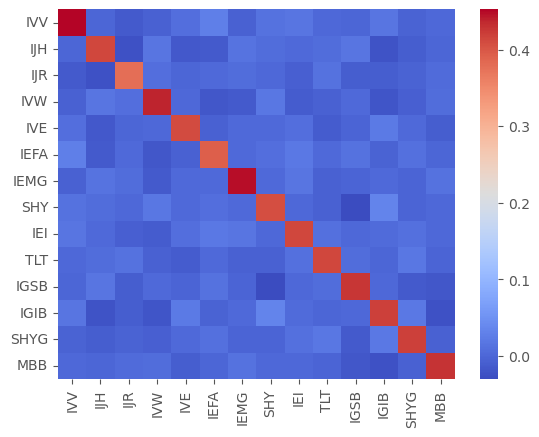

In [48]:
import seaborn as sns
sns.heatmap(shrunk_cov*100, cmap='coolwarm')

In [58]:
from optimizer import CVXOptimisation
gamma_values = np.logspace(1, 3, 50)
gamma_values = gamma_values[::-1]
A = np.array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])
ub = np.array([[0.65]])
lb = np.array([[0.55]])
ret_vals = []
risk_vals = []

for risk_aversion in gamma_values:
    o = CVXOptimisation()
    o.set_objective(expected_returns, shrunk_cov, risk_aversion)
    o.set_constraints(
    {
        'min_weight': 0.05,
        'max_weight': 0.15,
        'sum_weights': 1.0,
        'factor_constraint' :[ A, lb, ub]
    })
    o.solve()
    if o._problem.status != 'optimal':
        print('Optimization problem not solved')
    else:
        weights = o.get_weights()
        ret = (expected_returns.T @ weights)*100
        ret_vals.append(ret.iloc[0, 0])
        risk = np.sqrt(weights.T @ cov @ weights)*100
        risk_vals.append(risk[0, 0])

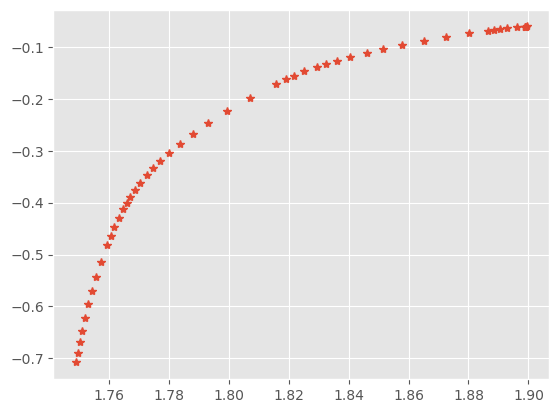

In [59]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1)
ax.plot(risk_vals, ret_vals, '*')

In [60]:
np.round(weights*100, 1)

array([[ 5. ],
       [15. ],
       [15. ],
       [ 5. ],
       [ 5. ],
       [ 5. ],
       [ 5. ],
       [ 5. ],
       [10.3],
       [ 5. ],
       [ 5. ],
       [ 9.7],
       [ 5. ],
       [ 5. ]])